Tabular shape: (2149, 35)
Predictions shape: (430, 3)
CNN feature shape: (1025, 49152)
Tabular scaled shape: (2149, 32)
Fusion feature shape: (1025, 49184)

Classification Report (Fusion Model):
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       103
           1       0.86      0.74      0.79       102

    accuracy                           0.81       205
   macro avg       0.82      0.81      0.81       205
weighted avg       0.82      0.81      0.81       205

ROC AUC Score: 0.871


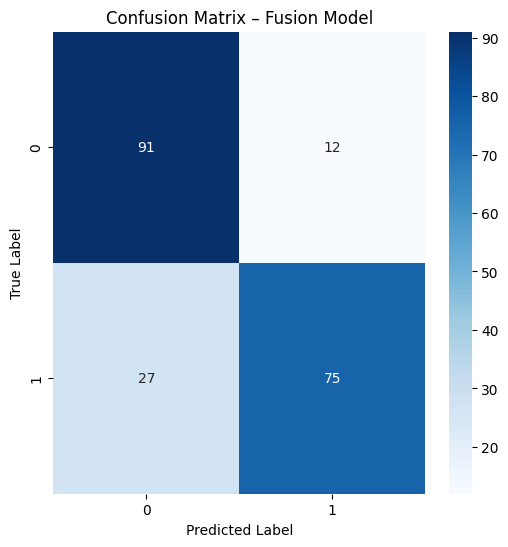

Sonuçlar kaydedildi: /Users/iremcelik/Desktop/alzheimer_prediction/data/results/fusion_results.csv


In [9]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Veri yolları
base_path = "/Users/iremcelik/Desktop/alzheimer_prediction/data"
cnn_model_path = "/Users/iremcelik/Desktop/alzheimer_prediction/notebooks/alzheimer_vgg16_finetuned.keras"
tabular_pred_path = f"{base_path}/results/tabular_predictions.csv"
text_data_path = f"{base_path}/raw/text_data/text_data.csv"

# 2. Tabular verileri yükle
tabular_df = pd.read_csv(text_data_path)
tab_pred = pd.read_csv(tabular_pred_path)

print(f"Tabular shape: {tabular_df.shape}")
print(f"Predictions shape: {tab_pred.shape}")

y_true_tab = tab_pred['y_true'].values
tabular_features = tabular_df.drop(['PatientID', 'Diagnosis', 'DoctorInCharge'], axis=1, errors='ignore')

scaler = StandardScaler()
tabular_scaled = scaler.fit_transform(tabular_features)

# 3. CNN modelinden görsel özellikleri çıkar
if not Path(cnn_model_path).exists():
    raise FileNotFoundError(f"CNN modeli bulunamadı: {cnn_model_path}")

cnn_model = load_model(cnn_model_path)
feature_extractor = cnn_model.layers[-2]  # sondan bir önceki katman

alz_dir = f"{base_path}/test/Alzheimer"
not_alz_dir = f"{base_path}/test/Not_Alzheimer"


def extract_cnn_features(folder_path):
    features = []
    for fname in os.listdir(folder_path):
        if not fname.endswith(".jpg"):
            continue
        img_path = os.path.join(folder_path, fname)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        feat = feature_extractor(img_array).numpy().flatten()
        features.append(feat)
    return np.array(features)

alz_features = extract_cnn_features(alz_dir)
not_alz_features = extract_cnn_features(not_alz_dir)

cnn_features = np.vstack([alz_features, not_alz_features])
cnn_labels = np.array([0]*len(alz_features) + [1]*len(not_alz_features))

print(f"CNN feature shape: {cnn_features.shape}")
print(f"Tabular scaled shape: {tabular_scaled.shape}")

# 4. Feature Fusion (birleştirme)
fusion_features = np.concatenate([cnn_features, tabular_scaled[:len(cnn_features)]], axis=1)
fusion_labels = cnn_labels

print(f"Fusion feature shape: {fusion_features.shape}")

# 5. Fusion Model (Random Forest)
X_train, X_test, y_train, y_test = train_test_split(
    fusion_features, fusion_labels, test_size=0.2, random_state=42, stratify=fusion_labels
)

fusion_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

fusion_model.fit(X_train, y_train)

# 6. Değerlendirme
y_pred = fusion_model.predict(X_test)
y_prob = fusion_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Fusion Model):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Fusion Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 7. Sonuçları kaydet
results_dir = f"{base_path}/results"
os.makedirs(results_dir, exist_ok=True)
output_path = os.path.join(results_dir, "fusion_results.csv")

results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "y_prob": y_prob
})
results_df.to_csv(output_path, index=False)

print(f"Sonuçlar kaydedildi: {output_path}")
